<a href="https://colab.research.google.com/github/yodavo/IAI_vaccines/blob/main/01-Preprocessing_VAERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar paquetes no disponibles
!pip install squarify

# Para importar la data
import os

# Importar para manipulacion de datos
import numpy as np
import pandas as pd
from statistics import *

# Importar para Visualizacion 
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import warnings # para evitar warnings
warnings.filterwarnings('ignore')
import textwrap
from textwrap import wrap
import squarify
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Importar Dependencias
%matplotlib inline
%load_ext google.colab.data_table

# CARGA Y REVISION PRELIMINAR

In [ ]:
# Carga de datos
%cd '/content/drive/MyDrive/Colab Notebooks/Diplomado-UTEC/Modulo5/dataset'

data = pd.read_csv('2021VAERSData.csv', index_col=0, encoding='latin-1')
symptom = pd.read_csv('2021VAERSSYMPTOMS.csv', index_col=0, encoding='latin-1')
vax = pd.read_csv('2021VAERSVAX.csv', index_col=0, encoding='latin-1')

print(data.shape)
print(symptom.shape)
print(vax.shape)

/content/drive/MyDrive/Colab Notebooks/Diplomado-UTEC/Modulo5/dataset
(428486, 34)
(575022, 10)
(445358, 7)


In [ ]:
# combinando datasets en un solo dataframe
df = pd.merge(data, symptom, on='VAERS_ID')
df = pd.merge(df, vax, on='VAERS_ID')
df.shape

(600588, 51)

In [ ]:
# haciendo una copia por si hay errores
dataset = df.copy()
dataset.VAX_TYPE.unique() # revisando el tipo de vacunas disponibles en el dataset

array(['COVID19', 'FLUC4', 'UNK', 'FLU4', 'FLUA3', 'VARZOS', 'DTAPHEPBIP',
       'HIBV', 'RV1', 'HPV9', 'DTAP', 'MMRV', 'TDAP', 'FLUR4', 'PNC13',
       'FLUX', 'HEP', 'PPV', 'FLUA4', 'FLUC3', 'HEPA', 'HPV4', 'MMR',
       'FLUN4', 'MENB', 'DTAPIPV', 'CHOL', 'DT', 'TTOX', 'FLU3', 'VARCEL',
       'MNQ', 'RV5', 'ANTH', 'IPV', 'TYP', 'EBZR', 'TD', 'HPVX',
       'FLUX(H1N1)', 'RVX', 'DTAPIPVHIB', 'HEPAB', 'MENHIB', 'DTP',
       'ADEN_4_7', 'FLU(H1N1)', 'RAB', 'YF', 'DF', 'PNC', 'JEV1', 'MEN',
       'MNQHIB', 'OPV', 'SMALL', 'FLUN3'], dtype=object)

In [ ]:
# separando el dataset de vacunas de covid19
dataset_covid = dataset[(dataset['VAX_TYPE'] == 'COVID19')]
print(dataset.shape)
print(dataset_covid.shape)

(600588, 51)
(591241, 51)


**Obs.** Cantidad exhorbitante de reportes de vacunas de Covid19 (casi 98% de los datos)

In [ ]:
# Conteo de fabricantes de vacunas para covid19 (VAX_MANU)
dataset_covid.groupby('VAX_MANU').size()

VAX_MANU
JANSSEN                  63676
MODERNA                 262333
PFIZER\BIONTECH         263821
UNKNOWN MANUFACTURER      1411
dtype: int64

**Obs.** Interesante los datos de el frabricante desconocido... por motivos de maleabilidad de los datos los eliminaremos al no ser muy representativo frente a los demas datos (representa solo un 0.16% de datos totales de vacunas para covid19)



In [ ]:
# revisamos la naturaleza de los datos
dataset_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591241 entries, 916600 to 1497727
Data columns (total 51 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   RECVDATE         591241 non-null  object 
 1   STATE            535248 non-null  object 
 2   AGE_YRS          558307 non-null  float64
 3   CAGE_YR          510323 non-null  float64
 4   CAGE_MO          936 non-null     float64
 5   SEX              591241 non-null  object 
 6   RPT_DATE         315 non-null     object 
 7   SYMPTOM_TEXT     591181 non-null  object 
 8   DIED             9434 non-null    object 
 9   DATEDIED         8835 non-null    object 
 10  L_THREAT         16254 non-null   object 
 11  ER_VISIT         50 non-null      object 
 12  HOSPITAL         53726 non-null   object 
 13  HOSPDAYS         39773 non-null   float64
 14  X_STAY           418 non-null     object 
 15  DISABLE          13438 non-null   object 
 16  RECOVD           541552 non-null

# EXPLORACIÓN DE DATOS POR VISUALIZACIÓN Y ANÁLISIS.

## % de DATOS por FABRICANTE DE VACUNAS

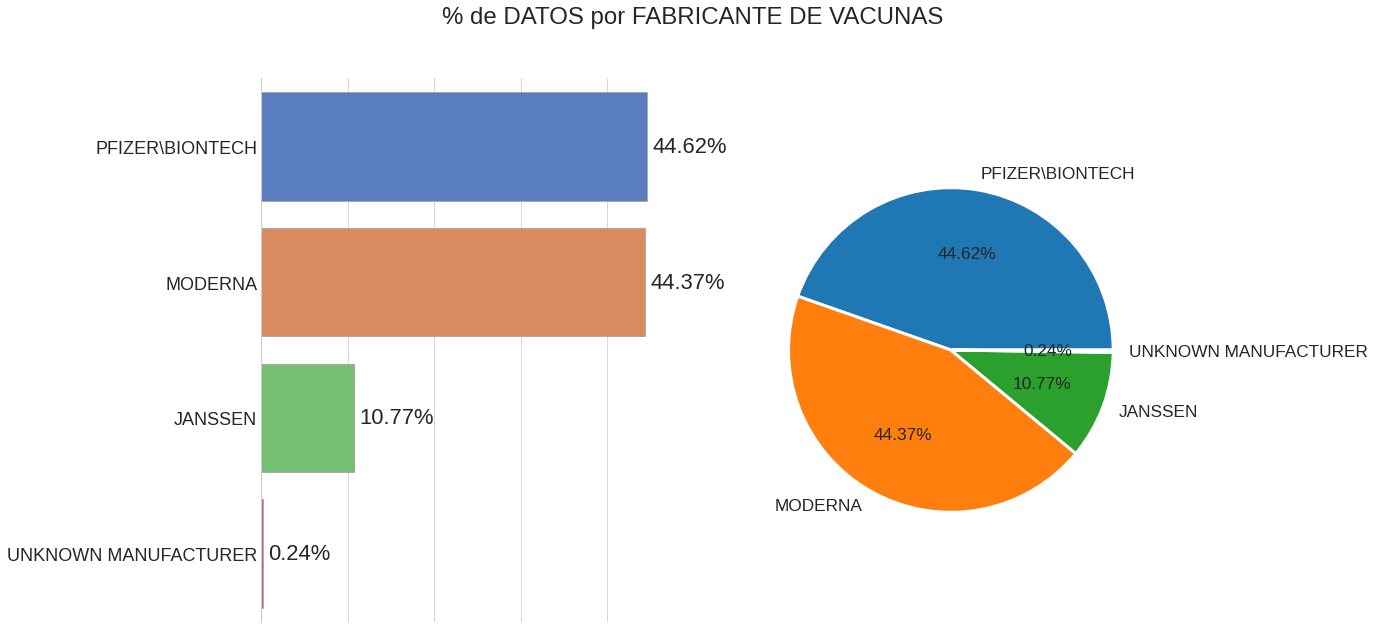

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,10))

sns.barplot(x=round((dataset_covid.VAX_MANU.value_counts()/dataset_covid.shape[0])*100,2), y=dataset_covid.VAX_MANU.value_counts().index,
           palette='muted', edgecolor='darkgray', ax=ax[0])
annot=round((dataset_covid.VAX_MANU.value_counts()/dataset_covid.shape[0])*100,2)

for p in ax[0].patches:
    width = p.get_width()
    annot = width.astype('str')
    ax[0].annotate(annot+'%', xy=(p.get_width(), p.get_y()+p.get_height()/2), fontsize=22,
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
    
ax[0].tick_params(axis='y', labelsize=18)
ax[0].tick_params(axis='x', labelbottom=False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_xlabel(" ")

labels = list(dataset_covid.VAX_MANU.value_counts().index)
ax[1].pie(round((dataset_covid.VAX_MANU.value_counts()/dataset_covid.shape[0])*100,2), labels=labels, 
         autopct = '%1.2f%%', textprops={'size': 'xx-large'}, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'})

plt.suptitle('% de DATOS por FABRICANTE DE VACUNAS', fontsize=24)
plt.show()

plt.show()

Después de eliminar el fabricante de vacunas desconocido (0,24%), ahora tenemos los datos que comprenden 44,62% de Moderna, 43,37% de Pfizer / BioNTech y 10,77% de Janssen.

## Revision de valores nulos

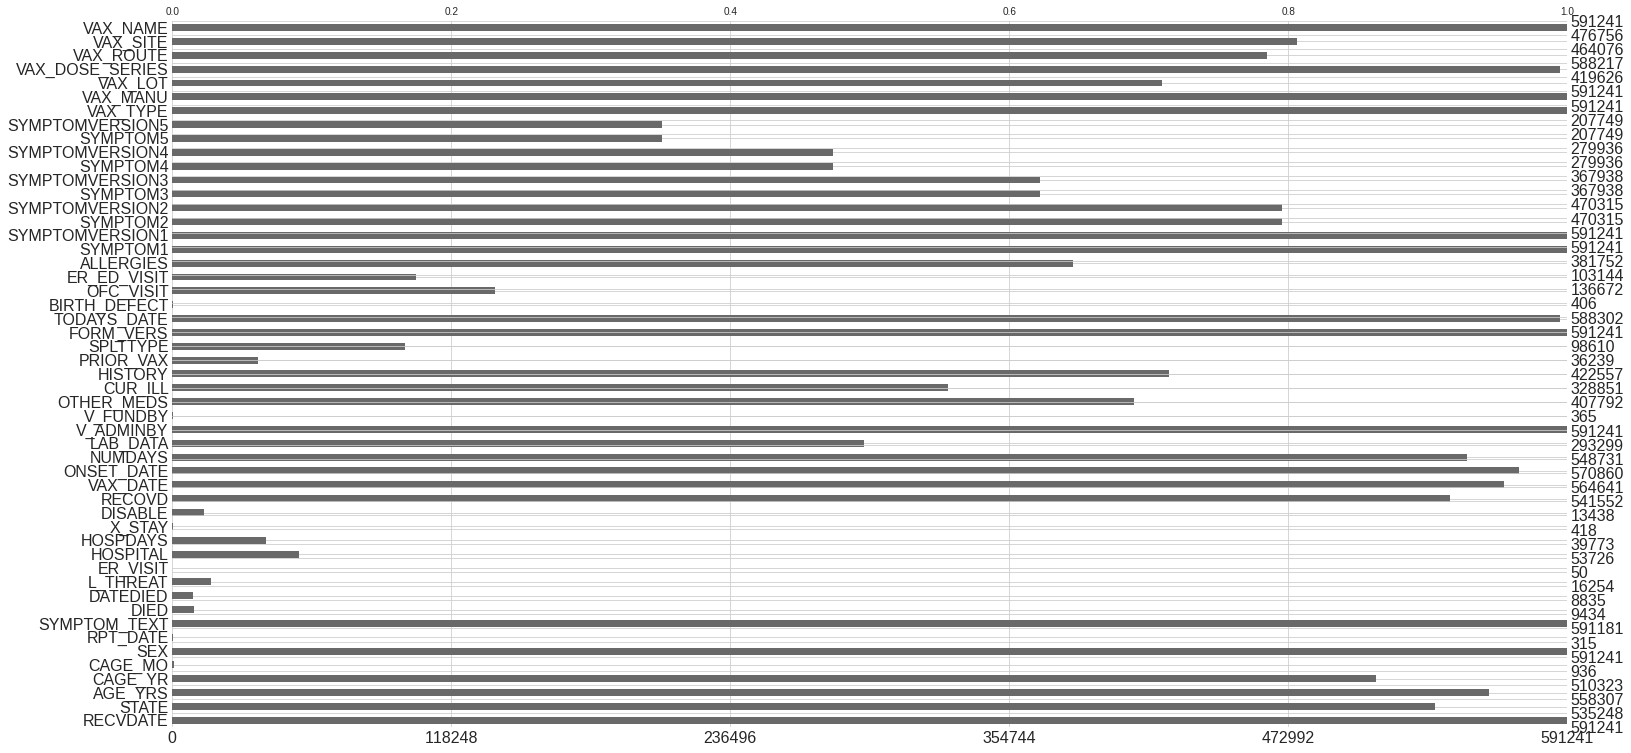

In [ ]:
msno.bar(dataset_covid)
plt.show()

**Obs.** Gran cantidad de las observaciones tienen datos perdidos.

## Analis de datos de pacientes que fallecieron

In [ ]:
print(f"Proporcion de muertes para Moderna: {mod.loc[mod['DIED'] == 'Y'].shape[0]}, frente al total de observaciones: {mod.shape[0]}. Proporción: {mod.loc[mod['DIED'] == 'Y'].shape[0]/mod.shape[0]:.5f}")
print(f"Proporcion de muertes para Pfizer: {pf.loc[pf['DIED'] == 'Y'].shape[0]}, frente al total de observaciones: {pf.shape[0]}. Proporción: {pf.loc[pf['DIED'] == 'Y'].shape[0]/pf.shape[0]:.5f}")
print(f"Proporcion de muertes para Jensen: {Jns.loc[Jns['DIED'] == 'Y'].shape[0]}, frente al total de observaciones: {Jns.shape[0]}. Proporción: {Jns.loc[Jns['DIED'] == 'Y'].shape[0]/Jns.shape[0]:.5f}")

Proporcion de muertes para Moderna: 4205, frente al total de observaciones: 262333. Proporción: 0.01603
Proporcion de muertes para Pfizer: 4354, frente al total de observaciones: 263821. Proporción: 0.01650
Proporcion de muertes para Jensen: 832, frente al total de observaciones: 63676. Proporción: 0.01307


## Analizando la Edad

In [ ]:
print('Los valores nulos dentro de la edad:', dataset_covid.AGE_YRS.isna().sum())

Los valores nulos dentro de la edad: 32934


AGE_YRS denota la edad del paciente. Los datos tienen 32934 valores nulos. Imputamos los valores nulos con 0. Luego formamos una columna adicional agrupando AGE_YRS de la siguiente manera:

* 0 <AGE_YRS <18 - 'Nino'
* 18 <= AGE_YRS <45 - 'Joven'
* 45 <= AGE_YRS <60 - 'Adulto'
* 60 <= AGE_YRS <80 - 'Adulto mayor'
* = 80 - 'Anciano' Los datos por grupo de edad son los siguientes:

In [ ]:
######################### Imputar los valores nulos con 0 y luego formar un grupo de edad ##########################

dataset_covid['AGE_YRS'] = dataset_covid['AGE_YRS'].fillna(0)
dataset_covid.AGE_YRS.isna().sum()

dataset_covid.loc[dataset_covid['AGE_YRS'] == 0, 'AGE'] = 'Desconocido'
dataset_covid.loc[((dataset_covid['AGE_YRS']>0) & (dataset_covid['AGE_YRS']<18)), 'AGE'] = 'Nino'
dataset_covid.loc[((dataset_covid['AGE_YRS']>=18) & (dataset_covid['AGE_YRS']<45)), 'AGE'] = 'Joven'
dataset_covid.loc[((dataset_covid['AGE_YRS']>=45) & (dataset_covid['AGE_YRS']<60)), 'AGE'] = 'Adulto'
dataset_covid.loc[((dataset_covid['AGE_YRS']>=60) & (dataset_covid['AGE_YRS']<80)), 'AGE'] = 'Adulto Mayor'
dataset_covid.loc[dataset_covid['AGE_YRS']>=80, 'AGE'] = 'Anciano'

print(dataset_covid.AGE.value_counts())

Joven           216942
Adulto          149055
Adulto Mayor    148489
Desconocido      32934
Anciano          24470
Nino             19351
Name: AGE, dtype: int64


## Separando el dataframe por vacunas para facilitar el Análisis

### Separacion del dataframe

Separamos los datos de 3 fabricantes de vacunas y los almacenamos en DataFrames:
* *mod - Moderna*
* *pf - Pfizer/BioNTech* 
* *Jns - Johnson & Johnson*

In [ ]:
mod = dataset_covid[dataset_covid['VAX_MANU'] =='MODERNA'].copy()
pf =  dataset_covid[dataset_covid['VAX_MANU'] =='PFIZER\BIONTECH'].copy()
Jns = dataset_covid[dataset_covid['VAX_MANU'] =='JANSSEN'].copy()
print('mod(Moderna) tiene {} observaciones'.format(mod.shape[0]))
print('pf(Pfizer/BioNTech) tiene {} observaciones'.format(pf.shape[0]))
print('Jns(Johnson & Johnson tiene {} observaciones'.format(Jns.shape[0]))

mod(Moderna) tiene 262333 observaciones
pf(Pfizer/BioNTech) tiene 263821 observaciones
Jns(Johnson & Johnson tiene 63676 observaciones


### Analisis por Edad

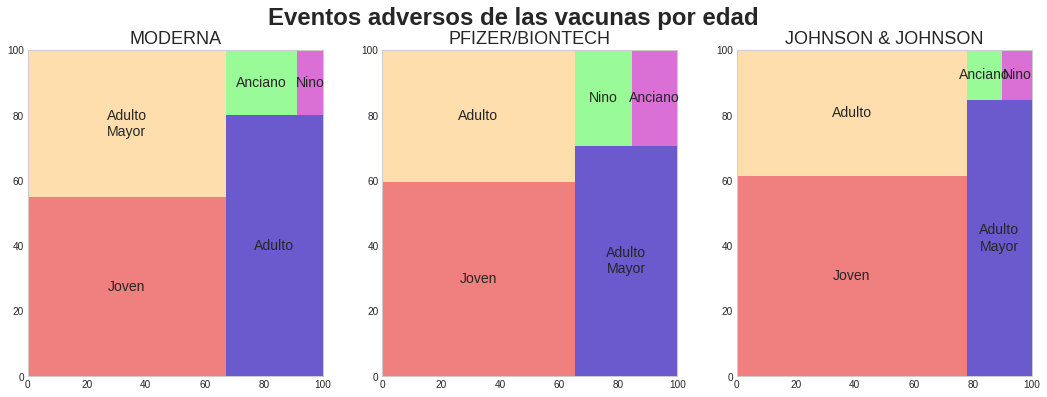

In [ ]:
############################ TreeMap de eventos adversos de vacunas por edad (AGE) ###############################################

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18,6))
col = ['lightcoral', 'navajowhite', 'slateblue', 'palegreen', 'orchid']

data = mod.AGE.value_counts().drop('Desconocido')
labels = [ '\n'.join(wrap(l, 10)) for l in data.index]
squarify.plot(sizes=data.values, label=labels, ax=ax[0], color=col, text_kwargs={'fontsize':14})
ax[0].set_title('MODERNA', fontsize=18)

data = pf.AGE.value_counts().drop('Desconocido')
labels = [ '\n'.join(wrap(l, 10)) for l in data.index]
squarify.plot(sizes=data.values, label=labels, ax=ax[1], color=col, text_kwargs={'fontsize':14})
ax[1].set_title('PFIZER/BIONTECH', fontsize=18)

data = Jns.AGE.value_counts().drop('Desconocido')
labels = [ '\n'.join(wrap(l, 10)) for l in data.index]
squarify.plot(sizes=data.values, label=labels, ax=ax[2], color=col, text_kwargs={'fontsize':14})
ax[2].set_title('JOHNSON & JOHNSON', fontsize=18)

plt.suptitle('Eventos adversos de las vacunas por edad', fontsize=24, fontweight='bold')
plt.show()

1. Para las 3 vacunas, el grupo de edad más afectado es el de 'Jovenes', que van desde los 18 a los 45 años.
2. Casi el 50% de los afectados por la vacuna Johnson & Johnson se encuentran en el grupo de edad de 18 a 45 años. Esto es alarmante.

### Analisis de los sintomas provocados post inoculacion

Los campos descritos en la guia proporcionan términos codificados de eventos adversos utilizando el diccionario "MedDRA". Puede haber una cantidad ilimitada de términos codificados para un evento determinado. Cada observacion de las tablas contendrá hasta 5 términos MedDRA por paciente.

**OBS**. Revisar terminos de MedDra. En base a la informacion encontrada puede tratarse de una familia/clasificación de sintomas. Necesitamos esclarecimiento. (Team de metodologia...)

In [ ]:
print('Los recuentos de MedDRA de SYMPTOM1 para 3 fabricantes de vacunas son:')
print('\nMODERNA: ', mod.groupby('SYMPTOMVERSION1').size())
print('\nPFIZER/BIONTECH: ', pf.groupby('SYMPTOMVERSION1').size())
print('\nJANSSEN: ', Jns.groupby('SYMPTOMVERSION1').size())

Los recuentos de MedDRA de SYMPTOM1 para 3 fabricantes de vacunas son:

MODERNA:  SYMPTOMVERSION1
23.1     22602
24.0    239731
dtype: int64

PFIZER/BIONTECH:  SYMPTOMVERSION1
23.1     39725
24.0    224096
dtype: int64

JANSSEN:  SYMPTOMVERSION1
23.1     9635
24.0    54041
dtype: int64


Hay 2 términos de síntomas codificados por eventos de MedDRA en 'SYMPTOM1': 23,1 y 24.

La proporción de ellos para los 3 fabricantes de vacunas es la siguiente

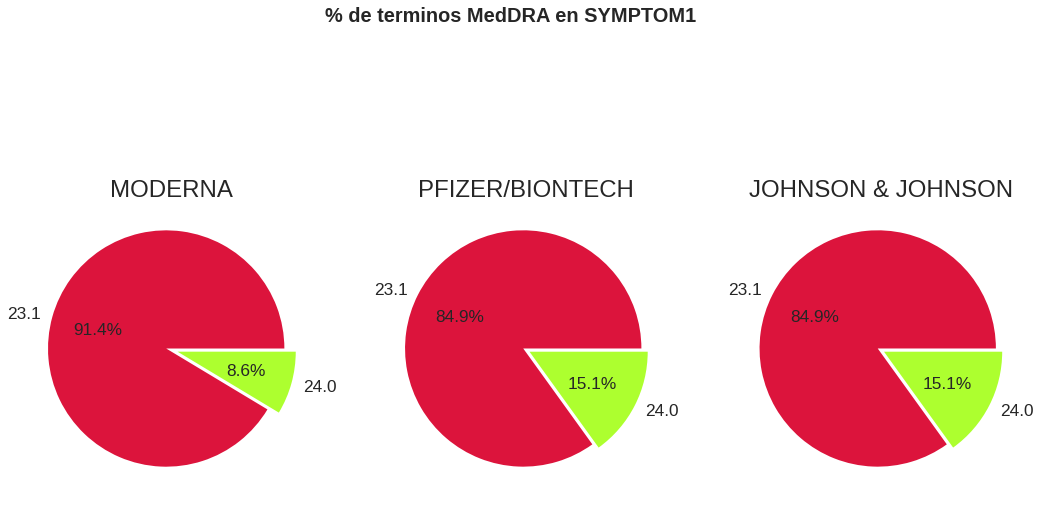

In [ ]:
############################# Visualizando SYMPTOMVERSION1 para Moderna, Pfizer, Janssen ##################################

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18,10))

labels = list(mod.SYMPTOMVERSION1.unique())
ax[0].pie(round((mod.SYMPTOMVERSION1.value_counts()/mod.shape[0])*100,2), labels = labels, autopct = '%1.1f%%',
         colors=['crimson', 'greenyellow'], explode =[0.05]*len(labels), textprops={'size': 'xx-large'})
ax[0].set_title('MODERNA', fontsize=24)

labels = list(pf.SYMPTOMVERSION1.unique())
ax[1].pie(round((pf.SYMPTOMVERSION1.value_counts()/pf.shape[0])*100,2), labels=labels, autopct = '%1.1f%%',
         colors=['crimson', 'greenyellow'], textprops={'size': 'xx-large'},explode =[0.03]*len(labels))
ax[1].set_title('PFIZER/BIONTECH', fontsize=24)

labels = list(Jns.SYMPTOMVERSION1.unique())
ax[2].pie(round((pf.SYMPTOMVERSION1.value_counts()/pf.shape[0])*100,2), labels=labels, autopct = '%1.1f%%',
         colors=['crimson', 'greenyellow'], textprops={'size': 'xx-large'},explode =[0.03]*len(labels))
ax[2].set_title('JOHNSON & JOHNSON', fontsize=24)
plt.suptitle('% de terminos MedDRA en SYMPTOM1', fontsize=20, fontweight='bold')
plt.show()

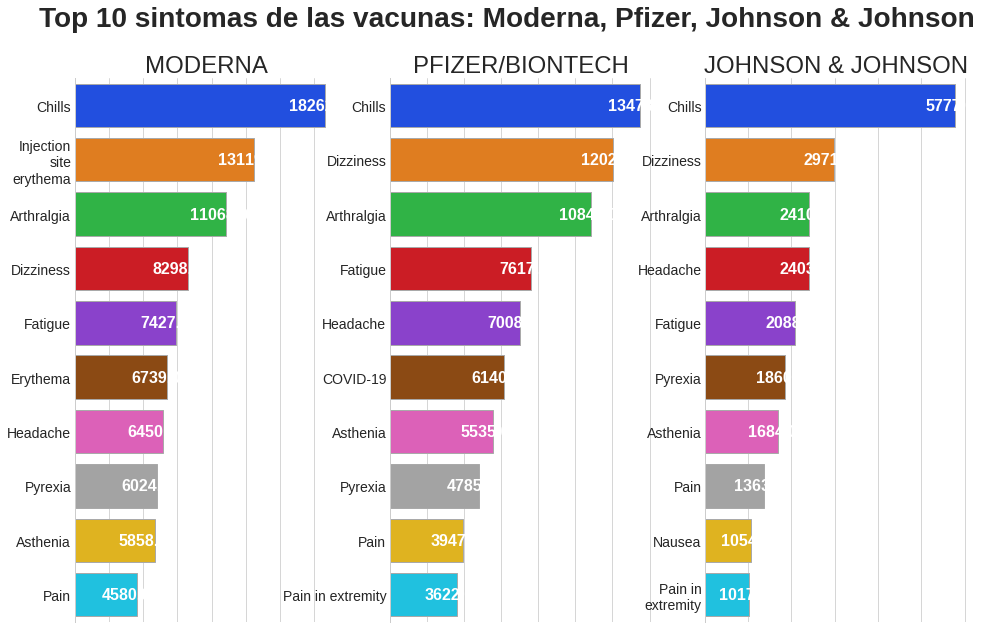

In [ ]:
############### Visualizando el Top 10 de los sintomas (SYMPTOM1) de Moderna, Pfizer, Janssen #############

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,10))

modSymp1 = mod.SYMPTOM1.value_counts().sort_values(ascending=False).head(10)
sns.barplot(y=modSymp1.index, x=modSymp1.values, ax=ax[0], palette='bright', edgecolor='darkgray')
ax[0].set_yticklabels([textwrap.fill(e, 10) for e in modSymp1.index])
for p in ax[0].patches:
    width = p.get_width()
    ax[0].annotate(p.get_width(), xy=(p.get_width()-3000, p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size=16, weight='bold', color='white')
ax[0].set_title('MODERNA', fontsize=24)

pfSymp1 = pf.SYMPTOM1.value_counts().sort_values(ascending=False).head(10)
sns.barplot(y=pfSymp1.index, x=pfSymp1.values, ax=ax[1], palette='bright', edgecolor='darkgray')
for p in ax[1].patches:
    width = p.get_width()
    ax[1].annotate(p.get_width(), xy=(p.get_width()-2000, p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size=16, weight='bold', color='white')
ax[1].set_title('PFIZER/BIONTECH', fontsize=24)

JnsSymp1 = Jns.SYMPTOM1.value_counts().sort_values(ascending=False).head(10)
sns.barplot(y=JnsSymp1.index, x=JnsSymp1.values, ax=ax[2], palette='bright', edgecolor='darkgray')
ax[2].set_yticklabels([textwrap.fill(e, 10) for e in JnsSymp1.index])
for p in ax[2].patches:
    width = p.get_width()
    ax[2].annotate(p.get_width(), xy=(p.get_width()-800, p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size=16, weight='bold', color='white')
ax[2].set_title('JOHNSON & JOHNSON', fontsize=24)

for i in range(3):
    ax[i].tick_params(axis='y', labelsize=14)
    ax[i].tick_params(axis='x', bottom=False, labelbottom=False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].set_xlabel(" ")

plt.suptitle('Top 10 sintomas de las vacunas: Moderna, Pfizer, Johnson & Johnson', fontsize=28, fontweight='bold')
plt.show()

La mayoría de los síntomas son comunes entre los 3 fabricantes de vacunas, a saber, escalofríos, mareos, artralgia (dolor en las articulaciones), dolor de cabeza, pirexia (fiebre), etc.

**Obs.** Observar la cantidad elevada de Eritremas post inoculacion en pacientes vacunados con Moderna.

### Analisos de efectos adversos por Sexo

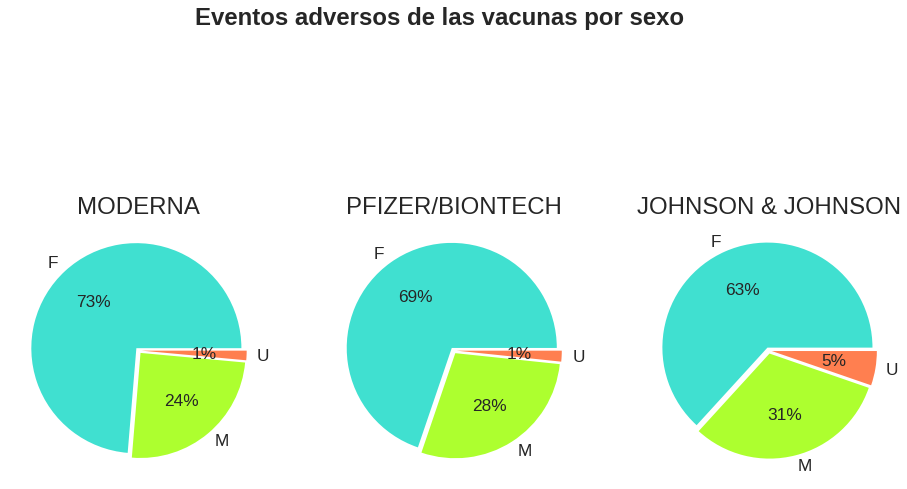

In [ ]:
################# Eventos adversos de las vacunas por sexo (SEX) #############################
################ More Females experienced Vaccine Adverse Events than males ###############

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,10))

data = mod.SEX.value_counts()
ax[0].pie(data.values, labels=data.index, autopct = '%d%%', explode =[0.03]*len(data.index),
          colors=['turquoise', 'greenyellow', 'coral'], textprops={'size': 'xx-large'})
ax[0].set_title('MODERNA', fontsize=24)

data = pf.SEX.value_counts()
ax[1].pie(data.values, labels=data.index, autopct = '%d%%', explode =[0.03]*len(data.index),
          colors=['turquoise', 'greenyellow', 'coral'],textprops={'size': 'xx-large'})
ax[1].set_title('PFIZER/BIONTECH', fontsize=24)

data = Jns.SEX.value_counts()
ax[2].pie(data.values, labels=data.index, autopct = '%d%%', explode =[0.03]*len(data.index),
          colors=['turquoise', 'greenyellow', 'coral'], textprops={'size': 'xx-large'})
ax[2].set_title('JOHNSON & JOHNSON', fontsize=24)

plt.suptitle('Eventos adversos de las vacunas por sexo',
             fontsize=24, fontweight='bold')

plt.show()

**Fueron mas mujeres las que experimentaron reacciones adversas a las vacunas que hombres**, este es fenómeno importante.

Esto es cierto para las 3 vacunas.
Es necesario ignorar los datos con etiquetas de sexo 'Desconocido'.

**Nota:** Necesitamos mas explicaciones de este asunto, probablemente ver las historial de vacunas, comorbolidades o enfermedades que tenian los pacientes antes de inocular la vacuna.

### Analisis de Sintomas vs Sexo por cada tipo de vacuna

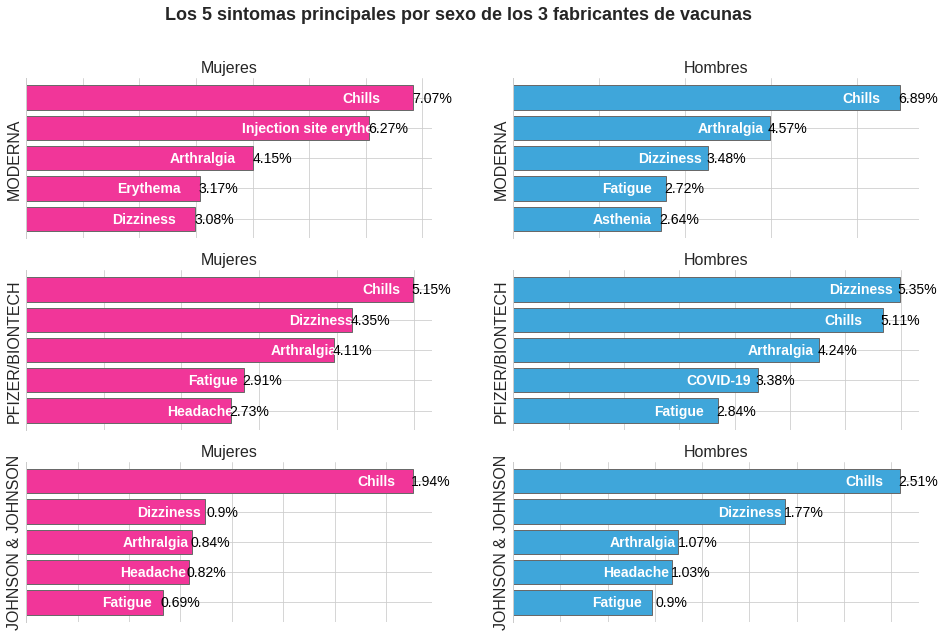

In [ ]:
############## Los 5 sintomas (SYMPTOM1) principales por sexo (SEX) para cada uno de los 3 fabricantes de vacunas  #############

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,10))

##################################### MODERNA #######################################

female = mod[mod['SEX'] == 'F']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)
male = mod[mod['SEX'] == 'M']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)

ax[0,0].barh(female.index, width=female.values, color='#F13699', edgecolor='dimgray')

for i in range(0,5):
    ax[0,0].annotate(list(female.index)[i], xy=(female.values[i]-1800,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((female.values[i]/mod['SEX'].value_counts()[0])*100, 2)
    annot = annot.astype('str')
    ax[0,0].annotate(annot+'%', xy=(female.values[i]+675,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[0,0].set_ylabel('MODERNA', fontsize=16)
ax[0,0].set_title('Mujeres', fontsize=16)

ax[0,1].barh(male.index, width=male.values, color='#3FA6DA', edgecolor='dimgray')
for i in range(0,5):
    ax[0,1].annotate(list(male.index)[i], xy=(male.values[i]-450,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((male.values[i]/mod['SEX'].value_counts()[1])*100, 2)
    annot = annot.astype('str')
    ax[0,1].annotate(annot+'%', xy=(male.values[i]+210,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[0,1].set_ylabel('MODERNA', fontsize=16)
ax[0,1].set_title('Hombres', fontsize=16)

############################ PFIZER/BIONTECH ################################

female = pf[pf['SEX'] == 'F']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)
male = pf[pf['SEX'] == 'M']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)

ax[1,0].barh(female.index, width=female.values, color='#F13699', edgecolor='dimgray')

for i in range(0,5):
    ax[1,0].annotate(list(female.index)[i], xy=(female.values[i]-800,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((female.values[i]/mod['SEX'].value_counts()[0])*100, 2)
    annot = annot.astype('str')
    ax[1,0].annotate(annot+'%', xy=(female.values[i]+475,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[1,0].set_ylabel('PFIZER/BIONTECH', fontsize=16)
ax[1,0].set_title('Mujeres', fontsize=16)

ax[1,1].barh(male.index, width=male.values, color='#3FA6DA', edgecolor='dimgray')
for i in range(0,5):
    ax[1,1].annotate(list(male.index)[i], xy=(male.values[i]-350,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((male.values[i]/mod['SEX'].value_counts()[1])*100, 2)
    annot = annot.astype('str')
    ax[1,1].annotate(annot+'%', xy=(male.values[i]+160,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[1,1].set_ylabel('PFIZER/BIONTECH', fontsize=16)
ax[1,1].set_title('Hombres', fontsize=16)

############################### JOHNSON and JOHNSON ########################################

female = Jns[Jns['SEX'] == 'F']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)
male = Jns[Jns['SEX'] == 'M']['SYMPTOM1'].value_counts(ascending=False).head(5).sort_values(ascending=True)

ax[2,0].barh(female.index, width=female.values, color='#F13699', edgecolor='dimgray')

for i in range(0,5):
    ax[2,0].annotate(list(female.index)[i], xy=(female.values[i]-350,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((female.values[i]/mod['SEX'].value_counts()[0])*100, 2)
    annot = annot.astype('str')
    ax[2,0].annotate(annot+'%', xy=(female.values[i]+175,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[2,0].set_ylabel('JOHNSON & JOHNSON', fontsize=16)
ax[2,0].set_title('Mujeres', fontsize=16)

ax[2,1].barh(male.index, width=male.values, color='#3FA6DA', edgecolor='dimgray')
for i in range(0,5):
    ax[2,1].annotate(list(male.index)[i], xy=(male.values[i]-150,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
    annot = round((male.values[i]/mod['SEX'].value_counts()[1])*100, 2)
    annot = annot.astype('str')
    ax[2,1].annotate(annot+'%', xy=(male.values[i]+80,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')

ax[2,1].set_ylabel('JOHNSON & JOHNSON', fontsize=16)
ax[2,1].set_title('Hombres', fontsize=16)

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].tick_params(axis='y', labelleft=False)
        ax[i,j].tick_params(axis='x', bottom=False, labelbottom=False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['bottom'].set_visible(False)
        ax[i,j].set_xlabel(" ")


plt.suptitle('Los 5 sintomas principales por sexo de los 3 fabricantes de vacunas', fontsize=18, fontweight='bold')
plt.show()

1. Los síntomas para mujeres y hombres son diferentes para las vacunas Moderna, mientras que son iguales, pero diferentes en volumen, para las vacunas de Pfizer / BioNTecn y Johnson & Johnson.
2. Los 5 síntomas principales son los mismos para las mujeres para las vacunas de Moderna y Johnson & Johnson: escalofríos, mareos, artralgia, dolor de cabeza, fatiga.
3. Hay un síntoma interesante para los hombres que tomaron la vacuna Pfizer / BioNTech: el 3,13% de los hombres **estaban infectados con el virus 'Covid-19'** contra el que tomaron la vacuna. **OBS.** Este no es un factor contraindicado?
4. Tanto para las vacunas Moderna ybJohnson & Johnson, las reacciones adversas n° 1 experimentaron "escalofríos" tanto en hombres como en mujeres.

### Analisis de Afectados por edad y sexp

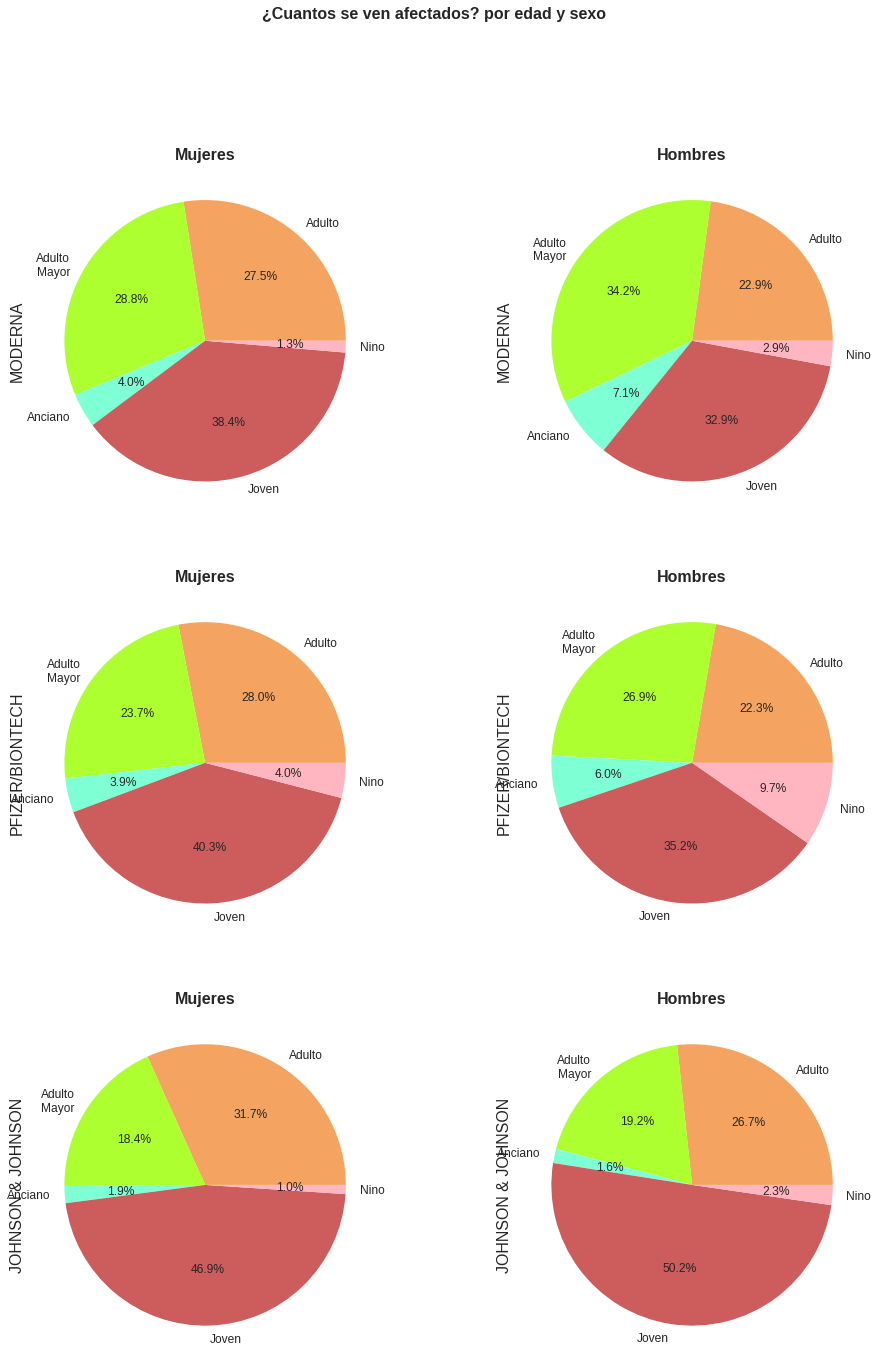

In [ ]:
############################## ¿Cuantos se ven afectados? por edad y sexo ##########################

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16,22))

col=['sandybrown', 'greenyellow', 'aquamarine', 'indianred', 'lightpink']
######################################## MODERNA ########################################
modDf = mod.groupby(['SEX']).AGE.value_counts().unstack()
modDf = pd.DataFrame(modDf)
modDf.drop('Desconocido', axis=1, inplace=True)
modDf.drop('U', axis=0, inplace=True)

lbl=([textwrap.fill(e, 10) for e in modDf.columns])

ax[0,0].pie(list(modDf[modDf.index == 'F'].values[0]), labels=lbl, autopct = '%1.1f%%',
            textprops={'size': 'large'}, colors=col)
           
ax[0,0].set_title('Mujeres', fontsize=16, fontweight='bold')
ax[0,0].set_ylabel('MODERNA', fontsize=16)
ax[0,1].pie(list(modDf[modDf.index == 'M'].values[0]), labels=lbl, autopct = '%1.1f%%',
            textprops={'size': 'large'}, colors=col)
ax[0,1].set_title('Hombres', fontsize=16, fontweight='bold')
ax[0,1].set_ylabel('MODERNA', fontsize=16)

################################# PFIZER/BIONTECH ##################################

pfDf = pf.groupby(['SEX']).AGE.value_counts().unstack()
pfDf = pd.DataFrame(pfDf)
pfDf.drop('Desconocido', axis=1, inplace=True)
pfDf.drop('U', axis=0, inplace=True)

lbl=([textwrap.fill(e, 10) for e in pfDf.columns])

ax[1,0].pie(list(pfDf[pfDf.index == 'F'].values[0]), labels=lbl, autopct = '%1.1f%%',
            textprops={'size': 'large'}, colors=col)
ax[1,0].set_title('Mujeres', fontsize=16, fontweight='bold')
ax[1,0].set_ylabel('PFIZER/BIONTECH', fontsize=16)
ax[1,1].pie(list(pfDf[pfDf.index == 'M'].values[0]), labels=lbl, autopct = '%1.1f%%',
            textprops={'size': 'large'}, colors=col)
ax[1,1].set_title('Hombres', fontsize=16, fontweight='bold')
ax[1,1].set_ylabel('PFIZER/BIONTECH', fontsize=16)

#################################### JOHNSON & JOHNSON ###################################

JnsDf = Jns.groupby(['SEX']).AGE.value_counts().unstack()
JnsDf = pd.DataFrame(JnsDf)
JnsDf.drop('Desconocido', axis=1, inplace=True)
JnsDf.drop('U', axis=0, inplace=True)

lbl=([textwrap.fill(e, 10) for e in JnsDf.columns])

ax[2,0].pie(list(JnsDf[JnsDf.index == 'F'].values[0]), labels=lbl, autopct = '%1.1f%%',
            textprops={'size': 'large'}, colors=col)
ax[2,0].set_title('Mujeres', fontsize=16, fontweight='bold')
ax[2,0].set_ylabel('JOHNSON & JOHNSON', fontsize=16)

ax[2,1].pie(list(JnsDf[JnsDf.index == 'M'].values[0]), labels=lbl, autopct = '%1.1f%%',
            textprops={'size': 'large'}, colors=col)
ax[2,1].set_title('Hombres', fontsize=16, fontweight='bold')
ax[2,1].set_ylabel('JOHNSON & JOHNSON', fontsize=16)

plt.suptitle('¿Cuantos se ven afectados? por edad y sexo', fontsize=16, fontweight='bold')
plt.show()

Un fenómeno a tener en cuenta:
Los "jovenes" (grupo de edad de 18 a 45 años) tienen más probabilidades de sufrir una reacción adversa a la vacuna, independientemente del tipo de fabricante de la vacuna.

Una tasa alarmante del +50% de los afectados por la vacuna Johnson and Johnson son adultos jóvenes.

### Analisis de los estados mas afectados en USA

In [ ]:
print('En total existen datos de {} estados'.format(dataset_covid['STATE'].nunique()), 
      '\nAnalizaremos los 5 estados más afectados y los 5 estados menos afectados por el fabricante de vacunas.')

En total existen datos de 64 estados 
Analizaremos los 5 estados más afectados y los 5 estados menos afectados por el fabricante de vacunas.


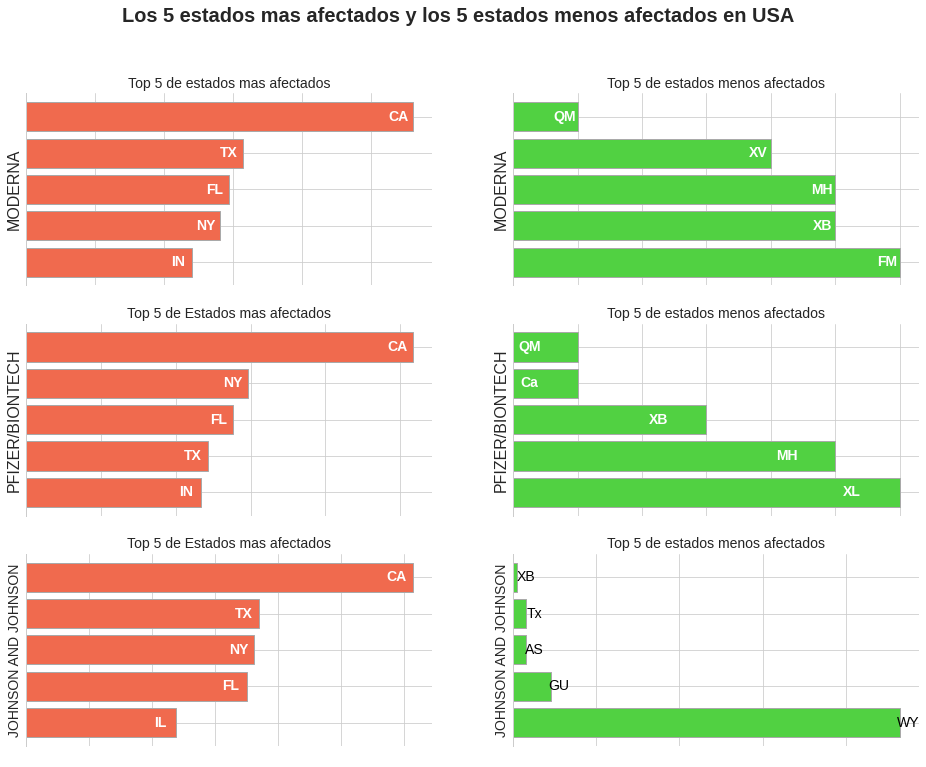

In [ ]:
########### Los 5 estados mas afectados y los 5 estados menos afectados ##########

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,12))

df_bad = mod['STATE'].value_counts(ascending=False).head(5).sort_values(ascending=True)
df_good = mod['STATE'].value_counts(ascending=True).head(5).sort_values(ascending=False)
ax[0,0].barh(df_bad.index, width=df_bad.values, color='#F06A4E', edgecolor='darkgray')

for i in range(0,5):
    ax[0,0].annotate(list(df_bad.index)[i], xy=(df_bad.values[i]-1000,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
ax[0,0].set_ylabel('MODERNA', fontsize=16)
ax[0,0].set_title('Top 5 de estados mas afectados', fontsize=14)

ax[0,1].barh(df_good.index, width=df_good.values, color='#51D142', edgecolor='darkgray')
for i in range(0,5):
    ax[0,1].annotate(list(df_good.index)[i], xy=(df_good.values[i]-0.20,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
ax[0,1].set_ylabel('MODERNA', fontsize=16)
ax[0,1].set_title('Top 5 de estados menos afectados', fontsize=14)


df_bad = pf['STATE'].value_counts(ascending=False).head(5).sort_values(ascending=True)
df_good = pf['STATE'].value_counts(ascending=True).head(5).sort_values(ascending=False)
ax[1,0].barh(df_bad.index, width=df_bad.values, color='#F06A4E', edgecolor='darkgray')

for i in range(0,5):
    ax[1,0].annotate(list(df_bad.index)[i], xy=(df_bad.values[i]-1000,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
ax[1,0].set_ylabel('PFIZER/BIONTECH', fontsize=16)
ax[1,0].set_title('Top 5 de Estados mas afectados', fontsize=14)

ax[1,1].barh(df_good.index, width=df_good.values, color='#51D142', edgecolor='darkgray')
for i in range(0,5):
    ax[1,1].annotate(list(df_good.index)[i], xy=(df_good.values[i]-0.75,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
ax[1,1].set_ylabel('PFIZER/BIONTECH', fontsize=16)
ax[1,1].set_title('Top 5 de estados menos afectados', fontsize=14)


df_bad = Jns['STATE'].value_counts(ascending=False).head(5).sort_values(ascending=True)
df_good = Jns['STATE'].value_counts(ascending=True).head(5).sort_values(ascending=False)
ax[2,0].barh(df_bad.index, width=df_bad.values, color='#F06A4E', edgecolor='darkgray')

for i in range(0,5):
    ax[2,0].annotate(list(df_bad.index)[i], xy=(df_bad.values[i]-250,i), 
             fontsize=14, ha='center', va='center', color='white', fontweight='bold')
ax[2,0].set_ylabel('JOHNSON AND JOHNSON', fontsize=14)
ax[2,0].set_title('Top 5 de Estados mas afectados', fontsize=14)

ax[2,1].barh(df_good.index, width=df_good.values, color='#51D142', edgecolor='darkgray')
for i in range(0,5):
    ax[2,1].annotate(list(df_good.index)[i], xy=(df_good.values[i]+2,i), 
             fontsize=14, ha='center', va='center', color='black', fontweight='light')
ax[2,1].set_ylabel('JOHNSON AND JOHNSON', fontsize=14)
ax[2,1].set_title('Top 5 de estados menos afectados', fontsize=14)


for i in range(0,3):
    for j in range(0,2):
        ax[i,j].tick_params(axis='y', labelleft=False)
        ax[i,j].tick_params(axis='x', bottom=False, labelbottom=False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['bottom'].set_visible(False)
        ax[i,j].set_xlabel(" ")

plt.suptitle('Los 5 estados mas afectados y los 5 estados menos afectados en USA', fontsize=20, fontweight='bold')
plt.show()

CA, NY, TX, IN y FL son los peores 5 estados afectados por las 3 vacunas, una posible razón es que estos 5 estados están densamente poblados y, por lo tanto, el número absoluto de vacunas y los efectos adversos (si los hay) son más altos que en el resto de los estados. 

Este es un fenómeno interesante y necesita más estudio sobre la proporción de afectados con respecto a la población de los estados.


### Analisis de los pacientes que requirieron hospitalización

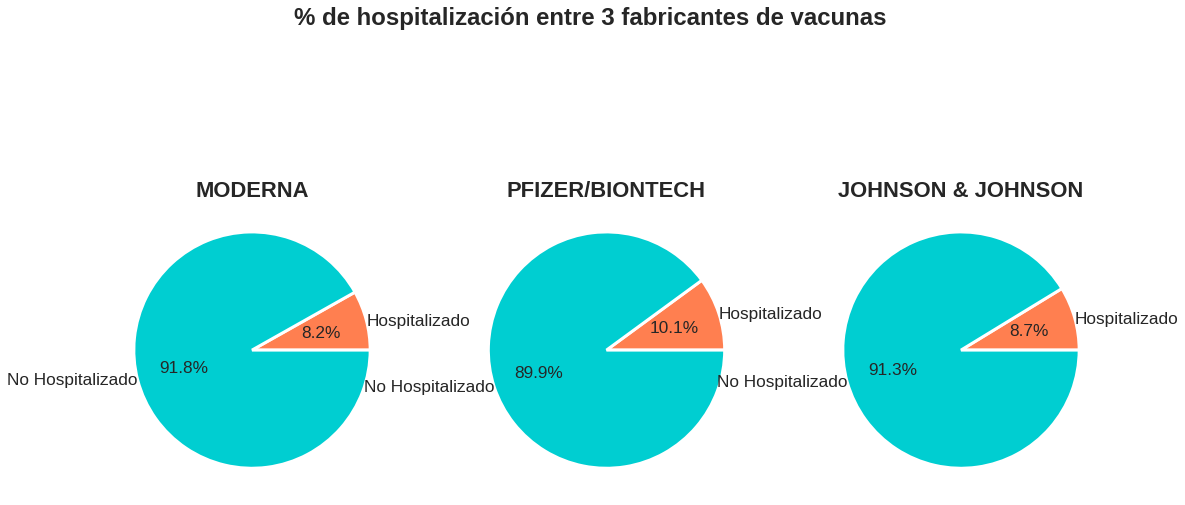

In [ ]:
################################################## Ratio de Hospitalizacion ############################################

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18,10))
labels='Hospitalizado', 'No Hospitalizado'
lbl=([textwrap.fill(e, 10) for e in labels])
col=['coral', 'darkturquoise']

modHosp = round(list((mod.HOSPITAL.value_counts().values/mod.shape[0])*100)[0], 2)
modNoHosp = 100 - modHosp
values=[modHosp, modNoHosp]
ax[0].pie(values, labels=labels, autopct = '%1.1f%%', textprops={'size': 'xx-large'}, colors=col,
         wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, labeldistance=1)
ax[0].set_title('MODERNA', fontsize=22, fontweight='bold')

pfHosp = round(list((pf.HOSPITAL.value_counts().values/pf.shape[0])*100)[0], 2)
pfNoHosp = 100 - pfHosp
values=[pfHosp, pfNoHosp]
ax[1].pie(values, labels=labels, autopct = '%1.1f%%', textprops={'size': 'xx-large'}, colors=col,
         wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, labeldistance=1)
ax[1].set_title('PFIZER/BIONTECH', fontsize=22, fontweight='bold')

JnsHosp = round(list((Jns.HOSPITAL.value_counts().values/Jns.shape[0])*100)[0], 2)
JnsNoHosp = 100 - JnsHosp
values=[JnsHosp, JnsNoHosp]
ax[2].pie(values, labels=labels, autopct = '%1.1f%%', textprops={'size': 'xx-large'}, colors=col,
         wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, labeldistance=1)
ax[2].set_title('JOHNSON & JOHNSON', fontsize=22, fontweight='bold')

plt.suptitle('% de hospitalización entre 3 fabricantes de vacunas', fontsize=24, fontweight='bold')
plt.show()

El % de hospitalización es inferior al 10.5% para cada uno de los 3 fabricantes de vacunas.

La hospitalización máxima ocurrió con las personas que tomaron la vacuna Pfizer / BioNTech, que es del 9,7%.

## Analisis por dias de hospitalizacion

In [ ]:
# revision de datos vacios
modHosp = mod[~mod.HOSPDAYS.isna()]
pfHosp = pf[~pf.HOSPDAYS.isna()]
JnsHosp = Jns[~Jns.HOSPDAYS.isna()]

print('Las resumenes estadisticos por los Días de Hospital son las siguientes:\n')
print('Para MODERNA\n', round(modHosp.HOSPDAYS.describe(),2))
print('\nPara PFIZER/BIONTECH\n', round(pfHosp.HOSPDAYS.describe(),2))
print('\nPara JOHNSON & JOHNSON\n', round(JnsHosp.HOSPDAYS.describe(),2))

Las resumenes estadisticos por los Días de Hospital son las siguientes:

Para MODERNA
 count    15889.00
mean        30.44
std       1586.42
min          1.00
25%          2.00
50%          3.00
75%          6.00
max      99999.00
Name: HOSPDAYS, dtype: float64

Para PFIZER/BIONTECH
 count    19602.00
mean         4.91
std          6.49
min          1.00
25%          2.00
50%          3.00
75%          5.00
max         92.00
Name: HOSPDAYS, dtype: float64

Para JOHNSON & JOHNSON
 count     4153.00
mean       149.97
std       3798.47
min          1.00
25%          2.00
50%          3.00
75%          6.00
max      99999.00
Name: HOSPDAYS, dtype: float64


Eliminamos las filas de datos con más de 30 días de hospitalización y EDAD = 'Desconocido'. También eliminamos las filas con SEXO 'Desconocido'.

In [ ]:
hosp_idx = modHosp[modHosp.HOSPDAYS >= 30].index
modHosp.drop(hosp_idx, inplace=True)
age_idx = modHosp[modHosp.AGE == 'Desconocido'].index
modHosp.drop(age_idx, inplace=True)
sex_idx = modHosp[modHosp['SEX'] == 'U'].index
modHosp.drop(sex_idx, inplace=True)

hosp_idx = pfHosp[pfHosp.HOSPDAYS >= 30].index
pfHosp.drop(hosp_idx, inplace=True)
age_idx = pfHosp[pfHosp.AGE == 'Desconocido'].index
pfHosp.drop(age_idx, inplace=True)
sex_idx = pfHosp[pfHosp['SEX'] == 'U'].index
pfHosp.drop(sex_idx, inplace=True)

hosp_idx = JnsHosp[JnsHosp.HOSPDAYS >= 30].index
JnsHosp.drop(hosp_idx, inplace=True)
age_idx = JnsHosp[JnsHosp.AGE == 'Desconocido'].index
JnsHosp.drop(age_idx, inplace=True)
sex_idx = JnsHosp[JnsHosp['SEX'] == 'U'].index
JnsHosp.drop(sex_idx, inplace=True)

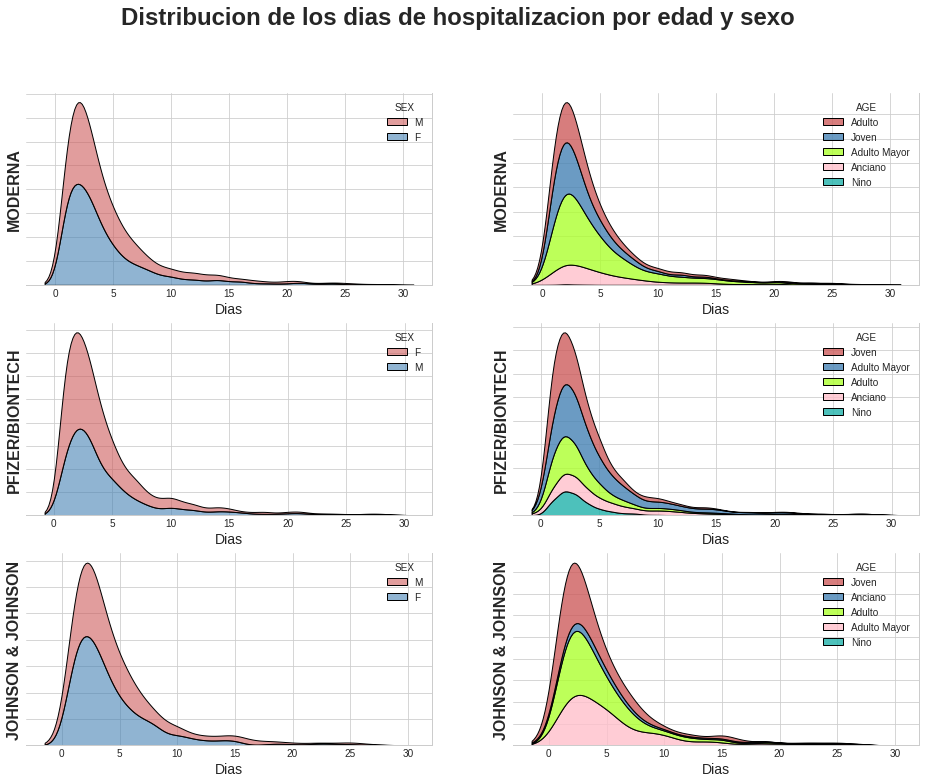

In [ ]:
############# Distribucion de los dias de hospitalizacion por edad y sexo ############################################
fig, ax =plt.subplots(ncols=2, nrows=3, figsize=(16,12))

sns.kdeplot(modHosp.HOSPDAYS, fill=True, alpha=0.6, hue = modHosp.SEX, 
                palette=('indianred', 'steelblue'), multiple='stack', ax=ax[0,0])
sns.kdeplot(modHosp.HOSPDAYS, fill=True, alpha=0.8, hue = modHosp.AGE, 
                palette=('indianred', 'steelblue', 'greenyellow', 'pink', 'lightseagreen'), multiple='stack', ax=ax[0,1])


sns.kdeplot(pfHosp.HOSPDAYS, fill=True, alpha=0.6, hue = pfHosp.SEX, 
                palette=('indianred', 'steelblue'), multiple='stack', ax=ax[1,0])
sns.kdeplot(pfHosp.HOSPDAYS, fill=True, alpha=0.8, hue = pfHosp.AGE, 
                palette=('indianred', 'steelblue', 'greenyellow', 'pink', 'lightseagreen'), multiple='stack', ax=ax[1,1])

sns.kdeplot(JnsHosp.HOSPDAYS, fill=True, alpha=0.6, hue = JnsHosp.SEX, 
                palette=('indianred', 'steelblue'), multiple='stack', ax=ax[2,0])
sns.kdeplot(JnsHosp.HOSPDAYS, fill=True, alpha=0.8, hue = JnsHosp.AGE, 
                palette=('indianred', 'steelblue', 'greenyellow', 'pink', 'lightseagreen'), multiple='stack', ax=ax[2,1])


for i in range(0,3):
    for j in range(0,2):
        ax[i,j].tick_params(left=False, labelleft=False)
        ax[i,j].set_xlabel('Dias', fontsize=14)
        ax[i,j].set_ylabel(' ')
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        
ax[0,0].set_ylabel('MODERNA', fontsize=16, fontweight='bold')
ax[0,1].set_ylabel('MODERNA', fontsize=16, fontweight='bold')
ax[1,0].set_ylabel('PFIZER/BIONTECH', fontsize=16, fontweight='bold')
ax[1,1].set_ylabel('PFIZER/BIONTECH', fontsize=16, fontweight='bold')
ax[2,0].set_ylabel('JOHNSON & JOHNSON', fontsize=16, fontweight='bold')
ax[2,1].set_ylabel('JOHNSON & JOHNSON', fontsize=16, fontweight='bold')
   
plt.suptitle('Distribucion de los dias de hospitalizacion por edad y sexo', fontsize=24, fontweight='bold')
plt.show()

1. Ya habíamos observado anteriormente que más mujeres sufrían reacciones adversas a las vacunas que hombres. Aquí, a partir de la distribución de la densidad de estancia hospitalaria, vemos que más hombres necesitaron más días en el hospital que mujeres que tomaron las vacunas Moderna o Johnson & Johnson.

2. Los 'jóvenes' en el grupo de edad de 18 a 45 años fueron hospitalizados la mayoría de los días que tomaron las vacunas Pfizer / BioNTech o Johnson & Johnson. Entre las personas que tomaron Moderna, el 'Adulto mayor', perteneciente a los 45-60 años, fue el que más días necesitó en el hospital.

## Conclusiones preliminares

1. Los 'jóvenes' son los más propensos a experimentar reacciones adversas a las vacunas.
2. La mayoría de los síntomas son comunes entre los 3 fabricantes de vacunas:
Escalofríos, mareos, artralgia (dolor en las articulaciones), dolor de cabeza, pirexia (fiebre), etc.
3. Fueron mas mujeres experimentaron eventos adversos a las vacunas que hombres.
4. CA, NY, TX, IN y FL son los peores 5 estados afectados por las 3 vacunas.
5. Nuevamente los 'jóvenes' que tomaron las vacunas Pfizer / BioNTech o Johnson & Johnson fueron hospitalizados por mas días. Entre las personas que tomaron Moderna, los 'Adultos' (perteneciente a los 45-60 años), fueron los que más días de hospitalizacin necesitaron.

# NOTAS FINALES

POSIBLES OBJETIVOS DEL TRABAJO DE INVESTIGACION:

1. Personalizacion de las vacunas Moderna, Pfizer  y Johnson & Johnson pra reducir efectos adversos en perfiles especificos en pacientes. Este objetivo requeriria de un dataset de control con pacientes que no presentaron reacciones adversas a las vacunas.

- Target: tipo de vacuna
- Features: Datos de los pacientes (alergias, comorbolidades, edad, sexo, 
enfermedades cronicas y actuales (historia clinica), vacunas previas, sintomas post aplicacion, hospitalizacion y dias de hospitilizacion, discapacidades...)

2. Series de tiempo frente antes y despues de la fecha de vacunacion.

3. Predecir el sexo y/o rango de edad basado en los sintomas presetnados post aplicacion de las vacunas A. B.

4. Predecir si el paciente requiere hospitalizacion basado en los sintomas que presenta al inocularse la vacuna por clusters (no supervisado).

5. Predecir que sintomas puede presentar el paciente en base a su sexo y la vacuna inoculada.